<a href="https://colab.research.google.com/github/TheAmirHK/AdeQuaT_Project_AI-and-Optimization/blob/main/SaarAM_OptExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [333]:
!pip install pyomo
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
!wget -N -q "https://matematica.unipv.it/gualandi/solvers/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64

!apt-get install -y -qq glpk-utils

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [743]:
# Define model
model = ConcreteModel()

In [744]:
# In[rail condition
np.random.seed(0)
rail_length = 29 # in meters
measurement_portion = 1 # measurement unit is 10 cm
defect_rate = 0.005 # some random number
vector_length = rail_length * measurement_portion # the length of the rail is discretized into units of measurement 115(m) * 10(cm) = 1150. so i would have a vector of zeroes and ones with the length of 1150.

def generate_defect_vector(length,defect_rate):
    num_ones = int(defect_rate * length)
    vector = np.zeros(length, dtype=int)
    indices = np.random.choice(length, size=num_ones, replace=False)
    vector[indices] = 1
    return vector

#defect_vector = generate_defect_vector(vector_length, defect_rate)
defect_vector =  (0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0)
defect_vector2 = (0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0)

defect_indices = np.where(np.array(defect_vector) == 1)[0]
defect_indices = np.concatenate(([0], defect_indices, [len(defect_vector)]))

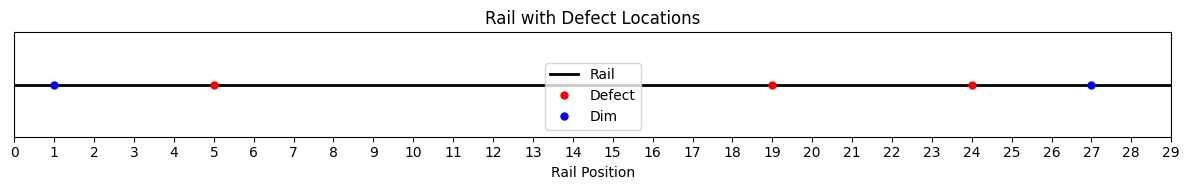

In [745]:
# In[this is a first plot of the rail. only with purpose of illustration][TO BE DELETED !!!]
def plot_rail(defect_vector, dim_vector, measurment_portion=1):
    length = len(defect_vector) / measurment_portion
    fig, ax = plt.subplots(figsize=(12, 2))

    ax.plot([0, length], [0, 0], color='black', linewidth=2, label='Rail')

    defect_indices = np.where(np.array(defect_vector) == 1)[0]
    dim_indicies = np.where(np.array(dim_vector) == 1)[0]
    defect_positions = defect_indices / measurement_portion
    dim_positions = dim_indicies / measurement_portion

    for pos1 in defect_positions:
        ax.plot(pos1, 0, 'ro', markersize=5, label='Defect' if pos1 == defect_positions[0] else "")

    for pos2 in dim_positions:
        ax.plot(pos2, 0, 'bo', markersize=5, label='Dim' if pos2 == dim_positions[0] else "")


    ax.set_xlabel('Rail Position')
    ax.set_ylabel('')
    ax.set_title('Rail with Defect Locations')
    ax.set_yticks([])
    ax.set_xlim(0, length)
    ax.set_ylim(-0.1, 0.1)
    ax.set_xticks(np.arange(0, length + 1, 1))
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_rail(defect_vector, defect_vector2)

In [746]:
# In[dataset]
# Sets
L = range(rail_length)

# Parameters
patterns = [2, 3]
P = range(len(patterns))

In [747]:
model.pert = Var(range(len(defect_indices)-1), within=NonNegativeReals)

model.coup = Var(P,L, within=NonNegativeIntegers)

In [748]:
def cost_rule(m):
    return sum(patterns[p]*model.coup[p,l] for p in P for l in L)
model.cost = Objective(rule=cost_rule, sense=maximize)

"""def cost_rule(m):
    return sum(model.pert[i] for i in range(len(defect_indices)-1))
model.cost = Objective(rule=cost_rule, sense=minimize)"""


# constraints
model.cut = ConstraintList()
for i in range(len(defect_indices) - 1):
    start_index = defect_indices[i]
    end_index = defect_indices[i + 1]
    for l in range(end_index - start_index):
        model.cut.add( sum( patterns[p] * model.coup[p,l + start_index ] for p in P) <= end_index - start_index - l )
for l in L:
  for p in P:
    model.cut.add(model.coup[p,l] <= ((1 - defect_vector[l]) * (1 - defect_vector2[l]) )*10)

In [749]:
"""for i in range(len(defect_indices) - 1):

    start_index = defect_indices[i]
    end_index = defect_indices[i + 1]
    model.cut.add( (end_index - start_index) - sum( patterns[p] * model.coup[p,l + start_index ] for p in P for l in range(end_index - start_index))  >= model.pert[i])"""

'for i in range(len(defect_indices) - 1):\n\n    start_index = defect_indices[i]\n    end_index = defect_indices[i + 1]\n    model.cut.add( (end_index - start_index) - sum( patterns[p] * model.coup[p,l + start_index ] for p in P for l in range(end_index - start_index))  >= model.pert[i])'

In [ ]:
solver = SolverFactory('glpk', executable='/usr/bin/glpsol')
results = solver.solve(model,tee = False)
results.write()

In [751]:
for p in P:
  for l in L:
    if model.coup[p,l].value > 0:
      print(f"model.coup[{p},{l}]: {model.coup[p,l].value}")

model.coup[0,0]: 1.0
model.coup[0,3]: 1.0
model.coup[0,6]: 2.0
model.coup[0,8]: 1.0
model.coup[0,9]: 2.0
model.coup[0,11]: 1.0
model.coup[0,12]: 2.0
model.coup[0,14]: 1.0
model.coup[0,15]: 2.0
model.coup[0,17]: 1.0
model.coup[0,20]: 2.0
model.coup[0,22]: 1.0
model.coup[0,25]: 2.0
model.coup[1,0]: 1.0
model.coup[1,2]: 1.0
model.coup[1,6]: 3.0
model.coup[1,7]: 4.0
model.coup[1,8]: 3.0
model.coup[1,9]: 2.0
model.coup[1,10]: 3.0
model.coup[1,11]: 2.0
model.coup[1,12]: 1.0
model.coup[1,13]: 2.0
model.coup[1,14]: 1.0
model.coup[1,16]: 1.0
model.coup[1,21]: 1.0
model.coup[1,26]: 1.0
